### XGBoost with randomized data

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRFRegressor
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score,roc_curve,auc,classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
X_train=pd.read_csv('data/train/f_hk_train.csv')
X_train

Month  spring  summer  winter  Mean Pressure(hPa)  pressure_sma_7  \
0         8       0       1       0           -1.292166       -1.434129   
1         1       0       0       1            1.778407        1.336904   
2        12       0       0       1            0.596236        0.781291   
3        12       0       0       1            1.824465        1.362692   
4         6       0       1       0           -1.599223       -1.877213   
...     ...     ...     ...     ...                 ...             ...   
8377      8       0       1       0           -0.644238       -1.101587   
8378      3       1       0       0            1.175414        0.547088   
8379     11       0       0       0            0.238875        0.527625   
8380      8       0       1       0           -1.113839       -1.758714   
8381     12       0       0       1            0.756592        0.793665   

      Absolute Daily Max(deg. C)  Mean(deg. C)  Absolute Daily min(deg. C)  \
0                       1.573352      1.446069                    1.395486   
1                      -1.621231     -1.807873                   -1.764257   
2                      -0.841158     -0.619307                   -0.426697   
3                      -1.695523     -1.593541                   -1.531638   
4                       0.886145      0.919983                    0.872093   
...                          ...           ...                         ...   
8377                    0.747796      0.781208                    0.682983   
8378                   -1.925158     -1.678568                   -1.503441   
8379                    0.032893      0.188903                    0.315558   
8380                    0.548979      0.852531                    0.988393   
8381                   -0.788826     -0.662869                   -0.508805   

      Mean Dew Point(deg. C)  ...  Mean Amount of Cloud(%)  cloud_sma_7  \
0                   1.035802  ...                -0.754471     0.097750   
1                  -1.737680  ...                -0.418444    -0.213663   
2                  -0.570788  ...                -0.712468    -0.769157   
3                  -2.363405  ...                 0.841655     0.459662   
4                   0.579192  ...                -0.334438     0.510162   
...                      ...  ...                      ...          ...   
8377                0.952973  ...                 0.490224     0.401775   
8378               -1.537805  ...                 1.002040     1.324289   
8379                0.195138  ...                 0.870884     0.718016   
8380                1.050111  ...                 0.922429     0.983424   
8381               -0.309977  ...                 0.399586     0.389069   

      Total Bright Sunshine(hours)  sunshine_sma_7  \
0                         1.260988        0.600734   
1                         0.721348        0.169234   
2                         0.824137        0.884615   
3                        -1.308726       -0.682412   
4                         0.669954       -0.290655   
...                            ...             ...   
8377                     -0.210598       -0.015705   
8378                     -1.210618       -1.648149   
8379                     -0.962347       -0.442303   
8380                     -1.277083       -0.826974   
8381                     -0.892200       -0.708298   

      Prevailling Wind Direction(degrees)  PWD_missing  Mean Wind Speed(km/h)  \
0                                1.248321        False              -0.128933   
1                               -0.681967        False               0.273090   
2                               -0.360252        False               1.981688   
3                               -1.003681        False               1.077136   
4                               -0.467490        False               1.479159   
...                                   ...          ...                    ...   
8377                            -0.373362        Fa

In [3]:
#get training set and test set by csv by reading csv file
y_train=pd.read_csv('data/train/t_hk_train.csv')
X_test=pd.read_csv('data/test/f_hk_test.csv')
y_test=pd.read_csv('data/test/t_hk_test.csv')
y_train.shape,X_test.shape,y_test.shape

((8382, 1), (1441, 22), (1441, 1))

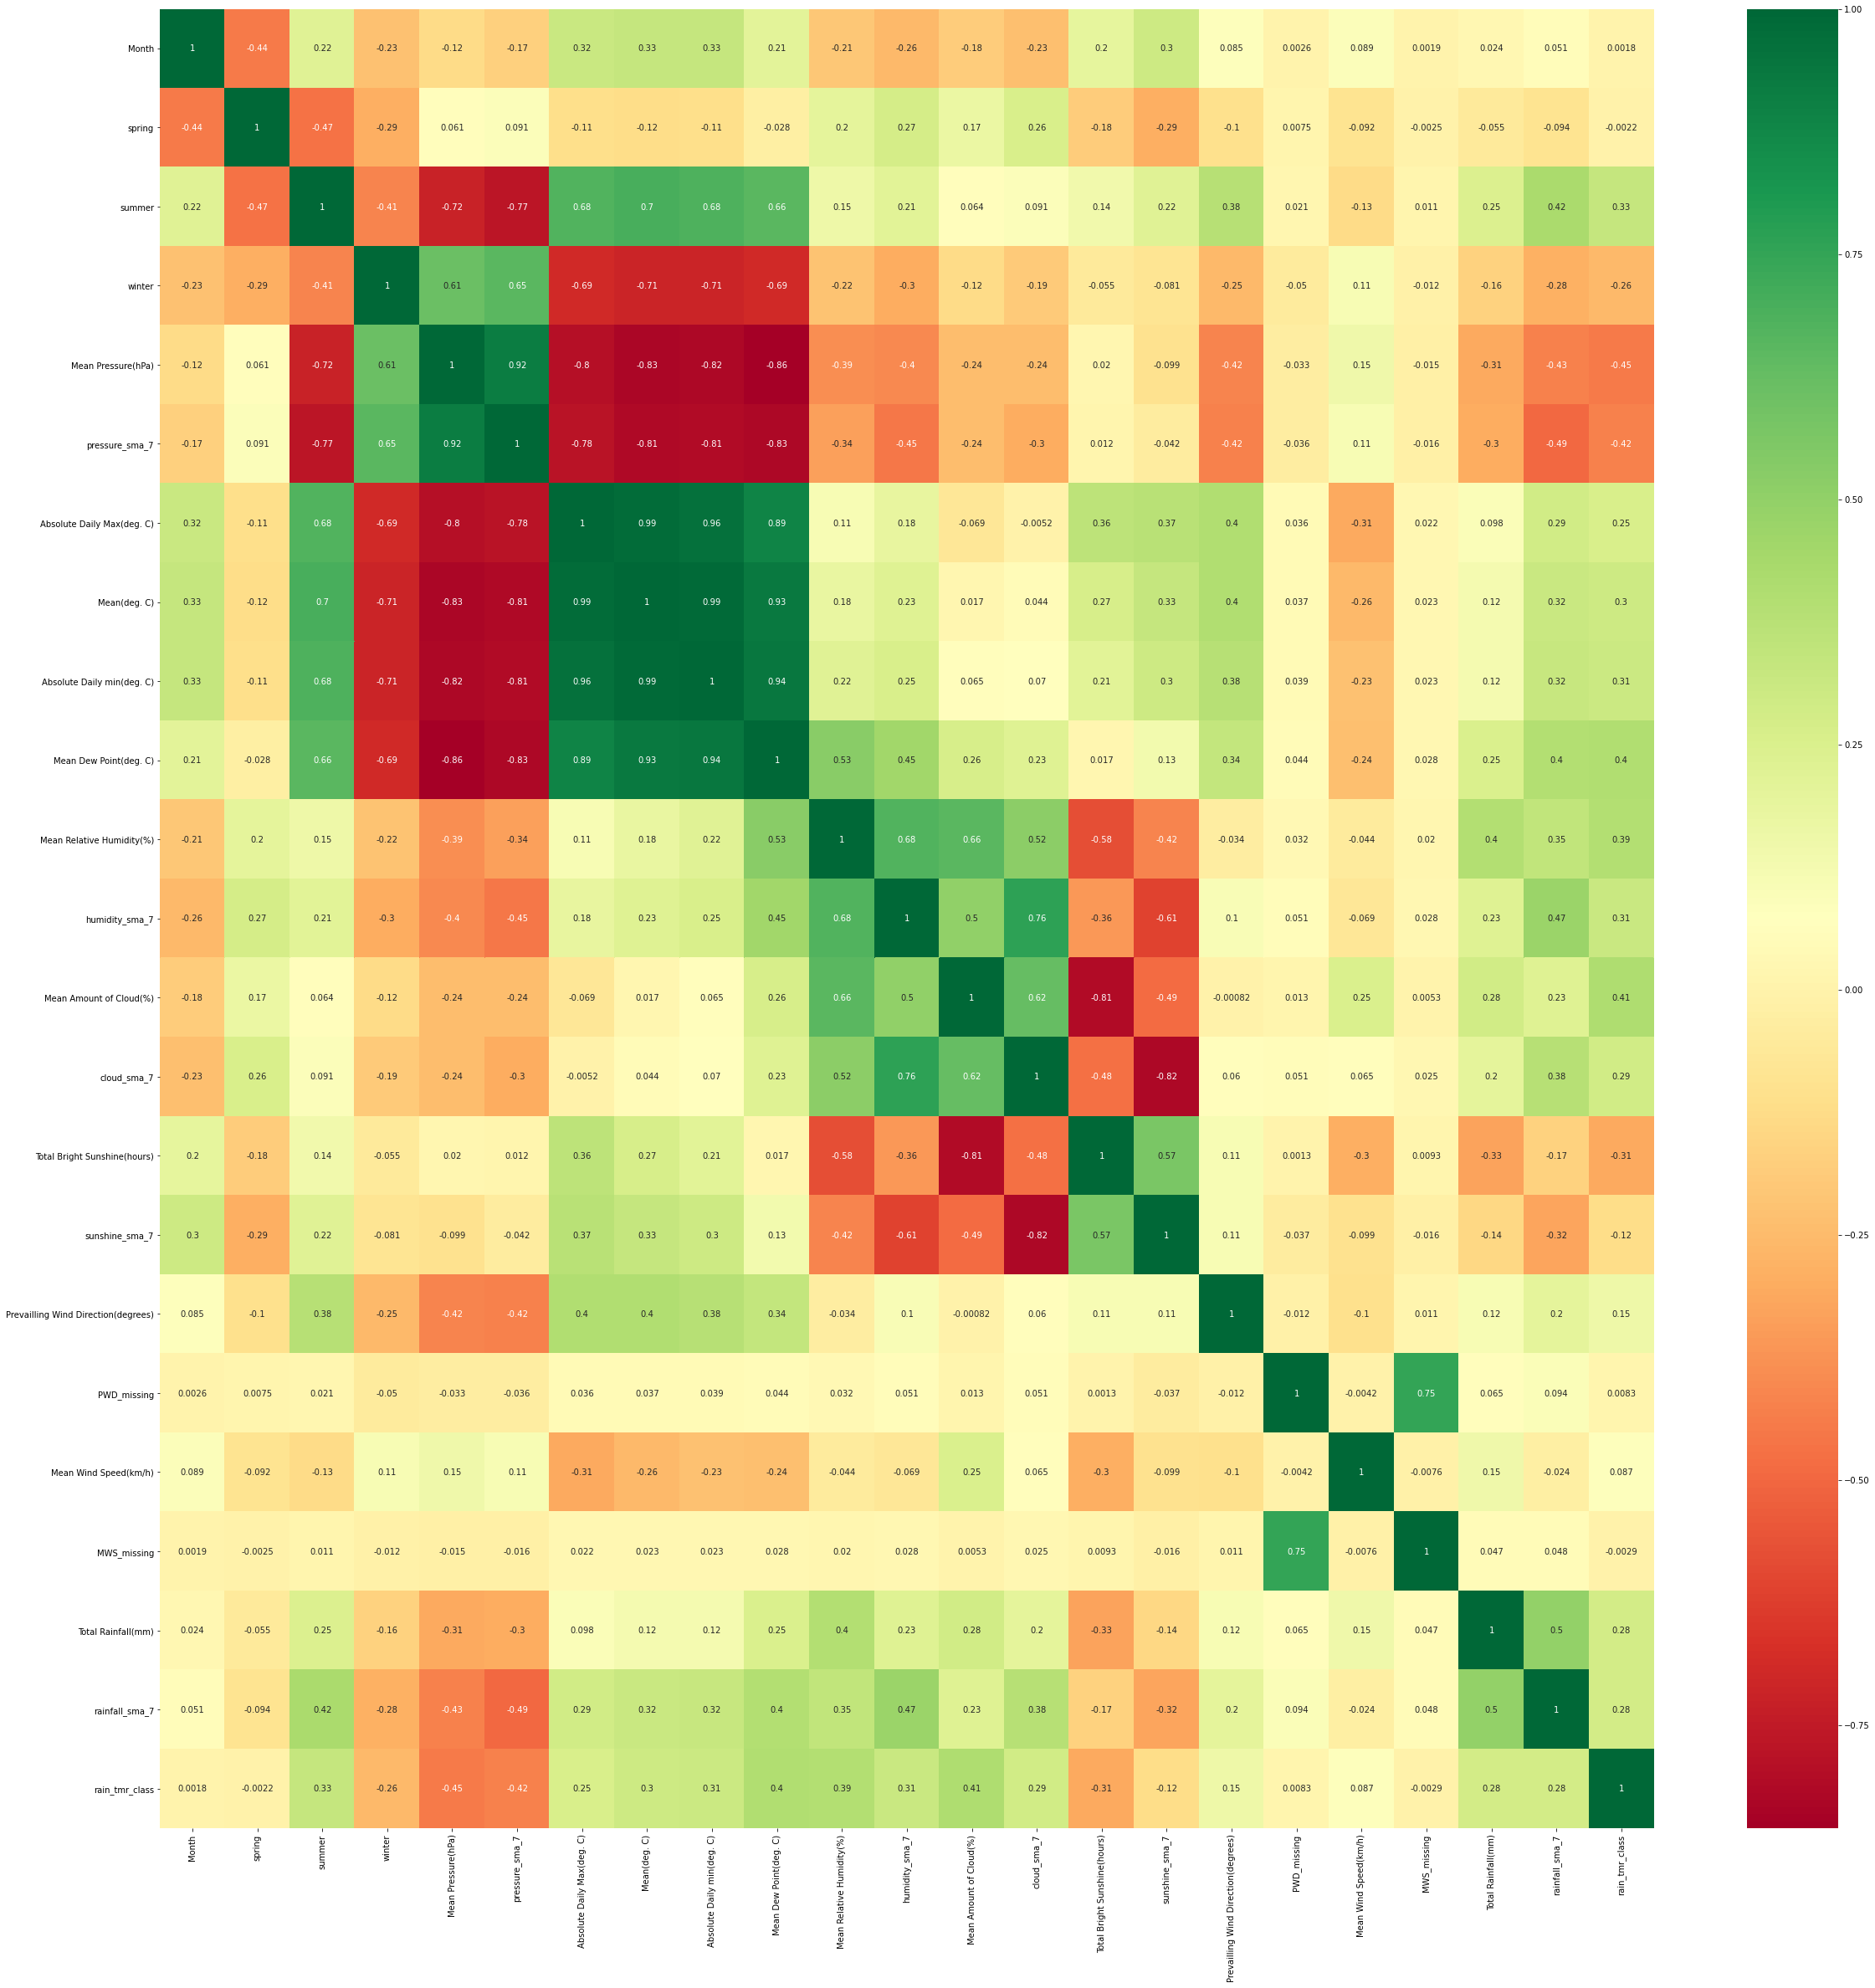

In [4]:
#concatenate features and target for correlation heatmap
train=pd.concat([X_train,y_train],axis=1)
test=pd.concat([X_test,y_test],axis=1)
data=pd.concat([train,test],axis=0)
plt.figure(figsize=(40,40))
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn')

In [5]:
X_train.drop(columns='Month',axis=1,inplace=True)
X_test.drop(columns='Month',axis=1,inplace=True)

In [6]:
#base xgboost model 
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=np.nan, monotone_constraints='()',
              n_estimators=8, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
              subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)
xg_clf.fit(X_train, y_train['rain_tmr_class'])
y_hat=xg_clf.predict(X_test)

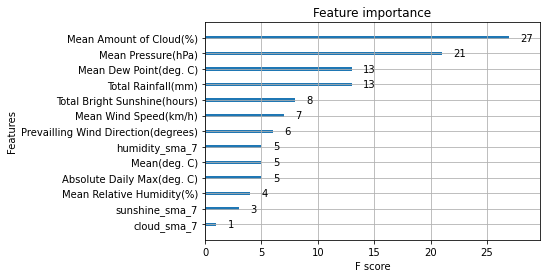

In [7]:
xgb.plot_importance(xg_clf)

cm:
[[734 285]
 [113 309]]
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1019
           1       0.52      0.73      0.61       422

    accuracy                           0.72      1441
   macro avg       0.69      0.73      0.70      1441
weighted avg       0.77      0.72      0.73      1441

Accuracy: 72.38%
f1: 0.6082677165354331
roc_auc: 0.7262707607588519


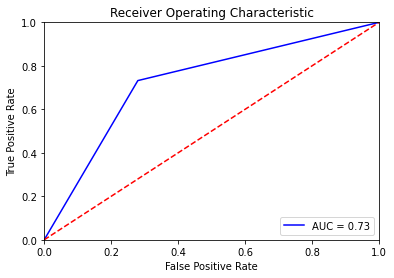

In [8]:
def print_metrics(y_test,y_hat):
    cm = confusion_matrix(y_test,y_hat)
    accuracy = accuracy_score(y_test, y_hat)
    f1 = f1_score(y_test,y_hat)
    roc_auc = roc_auc_score(y_test,y_hat)
    print('cm:')
    print(cm)
    print(classification_report(y_test,y_hat))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print('f1:',f1)
    print('roc_auc:',roc_auc)

    fpr, tpr, threshold = roc_curve(y_test, y_hat)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
print_metrics(y_test,y_hat)

### XGBoost with common columns as AUS

In [9]:
X_train.columns

Index(['spring', 'summer', 'winter', 'Mean Pressure(hPa)', 'pressure_sma_7',
       'Absolute Daily Max(deg. C)', 'Mean(deg. C)',
       'Absolute Daily min(deg. C)', 'Mean Dew Point(deg. C)',
       'Mean Relative Humidity(%)', 'humidity_sma_7',
       'Mean Amount of Cloud(%)', 'cloud_sma_7',
       'Total Bright Sunshine(hours)', 'sunshine_sma_7',
       'Prevailling Wind Direction(degrees)', 'PWD_missing',
       'Mean Wind Speed(km/h)', 'MWS_missing', 'Total Rainfall(mm)',
       'rainfall_sma_7'],
      dtype='object')

In [10]:
common_cols=['Mean Pressure(hPa)', 'Mean(deg. C)','Mean Relative Humidity(%)','Mean Amount of Cloud(%)',
            'Total Bright Sunshine(hours)','Mean Wind Speed(km/h)','Total Rainfall(mm)']
X_train_common=X_train[common_cols]
X_test_common=X_test[common_cols]


In [11]:
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=np.nan, monotone_constraints='()',
              n_estimators=8, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
              subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)
xg_clf.fit(X_train_common, y_train['rain_tmr_class'])
y_hat=xg_clf.predict(X_test_common)
xg_clf.get_booster().get_score(importance_type="weight")

{'Total Rainfall(mm)': 15,
 'Mean Pressure(hPa)': 32,
 'Mean Amount of Cloud(%)': 28,
 'Total Bright Sunshine(hours)': 6,
 'Mean Wind Speed(km/h)': 10,
 'Mean(deg. C)': 19,
 'Mean Relative Humidity(%)': 8}

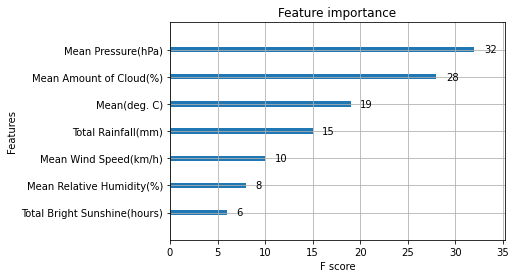

In [12]:
xgb.plot_importance(xg_clf)

cm:
[[728 291]
 [111 311]]
              precision    recall  f1-score   support

           0       0.87      0.71      0.78      1019
           1       0.52      0.74      0.61       422

    accuracy                           0.72      1441
   macro avg       0.69      0.73      0.70      1441
weighted avg       0.76      0.72      0.73      1441

Accuracy: 72.10%
f1: 0.607421875
roc_auc: 0.7256963661986242


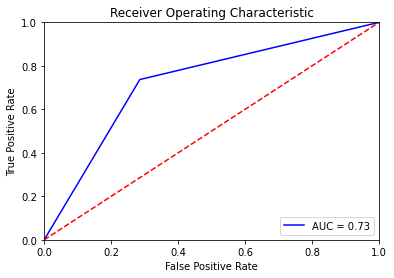

In [13]:
print_metrics(y_test,y_hat)

### XGBoost with common columns as AUS and without randomization

In [14]:
X_train_to=pd.read_csv('data/train/f_hk_train_to.csv', index_col=0)
y_train_to=pd.read_csv('data/train/t_hk_train_to.csv', index_col=0)
X_test_to=pd.read_csv('data/test/f_hk_test_to.csv', index_col=0)
y_test_to=pd.read_csv('data/test/t_hk_test_to.csv', index_col=0)

In [15]:
X_train_to

Month  spring  summer  winter  Mean Pressure(hPa)  pressure_sma_7  \
0         1       0       0       1            0.673000        0.717993   
1         1       0       0       1            0.688353        0.726198   
2         1       0       0       1            0.626942        0.707053   
3         1       0       0       1            0.519472        0.668762   
4         1       0       0       1            0.181709        0.573581   
...     ...     ...     ...     ...                 ...             ...   
8417      5       1       0       0           -0.649776       -0.625099   
8418      6       0       1       0           -1.213954       -1.298093   
8419      6       0       1       0           -1.957589       -1.594059   
8420      7       0       1       0           -1.067580       -1.450651   
8421     11       0       0       0            0.880880        0.872095   

      Absolute Daily Max(deg. C)  Mean(deg. C)  Absolute Daily min(deg. C)  \
0                      -0.618280     -0.853124                   -0.872550   
1                      -0.451122     -0.619307                   -0.756241   
2                      -1.026890     -0.853124                   -0.678701   
3                      -1.026890     -0.911578                   -0.814396   
4                      -0.525414     -0.580338                   -0.659316   
...                          ...           ...                         ...   
8417                    0.657203      0.712014                    0.360667   
8418                    0.619135      0.677504                    0.616774   
8419                    0.964442      1.088682                    0.887802   
8420                    0.627709      0.738500                    0.777943   
8421                   -0.604355     -0.420762                   -0.310974   

      Mean Dew Point(deg. C)  ...  Mean Amount of Cloud(%)  cloud_sma_7  \
0                  -1.027398  ...                -2.602617    -3.664456   
1                  -1.061221  ...                -2.770630    -3.782288   
2                  -1.111955  ...                -2.434604    -3.664456   
3                  -0.909018  ...                -0.334438    -2.869091   
4                  -0.604611  ...                -1.174504    -2.627535   
...                      ...  ...                      ...          ...   
8417                0.882046  ...                 0.866086     1.072869   
8418                0.924502  ...                 0.508502     1.213412   
8419                1.105586  ...                 0.732665     0.520924   
8420                0.966710  ...                 0.764246     0.685955   
8421               -0.063955  ...                 0.934904     0.035218   

      Total Bright Sunshine(hours)  sunshine_sma_7  \
0                         1.209594        1.883879   
1                         1.081108        1.784520   
2                         1.004017        1.711657   
3                        -0.306537        1.168497   
4                         0.412982        1.065164   
...                            ...             ...   
8417                     -1.090038       -1.029268   
8418                     -0.195627       -1.414538   
8419                     -0.480878        0.325318   
8420                     -1.104988       -0.345569   
8421                     -1.308726       -0.254380   

      Prevailling Wind Direction(degrees)  PWD_missing  Mean Wind Speed(km/h)  \
0                               -0.896443        False              -1.033484   
1                               -1.110920        False              -1.335001   
2                               -0.789205        False               0.373596   
3                               -0.789205        False               0.273090   
4                               -0.896443        False              -0.631461   
...                                   ...          ...                    ...   
8417                             1.293186        Fa

In [16]:
X_train_common_to=X_train_to[common_cols]
X_test_common_to=X_test_to[common_cols]

In [17]:
X_train_common_to.shape,X_test_common_to.shape

((8422, 7), (1441, 7))

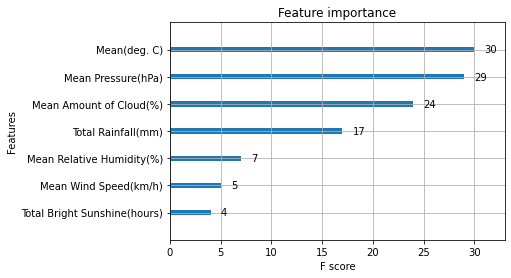

In [18]:
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=7, missing=np.nan, monotone_constraints='()',
              n_estimators=8, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1,
              subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=None)

xg_clf.fit(X_train_common_to, y_train_to['rain_tmr_class'])
y_hat=xg_clf.predict(X_test_common_to)
xgb.plot_importance(xg_clf)


cm:
[[695 304]
 [ 78 364]]
              precision    recall  f1-score   support

           0       0.90      0.70      0.78       999
           1       0.54      0.82      0.66       442

    accuracy                           0.73      1441
   macro avg       0.72      0.76      0.72      1441
weighted avg       0.79      0.73      0.74      1441

Accuracy: 73.49%
f1: 0.6558558558558558
roc_auc: 0.7596125537302008


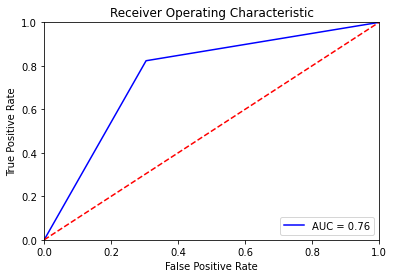

In [19]:
print_metrics(y_test_to,y_hat)

### Random Forest with common columns as AUS

cm:
[[756 263]
 [121 301]]
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      1019
           1       0.53      0.71      0.61       422

    accuracy                           0.73      1441
   macro avg       0.70      0.73      0.70      1441
weighted avg       0.77      0.73      0.74      1441

Accuracy: 73.35%
f1: 0.6105476673427991
roc_auc: 0.7275869847308718


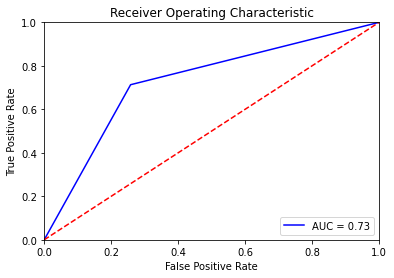

In [20]:
forest = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42,max_depth=5,max_features=3)
forest.fit(X_train_common, y_train['rain_tmr_class'])
y_hat = forest.predict(X_test_common)
print_metrics(y_test,y_hat)

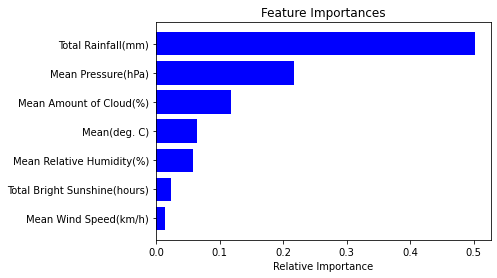

In [21]:
importances = forest.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train_common.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Random forest without randomized data

<ipython-input-22-c65ad8b9a4ed>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train_common_to, y_train_to)


cm:
[[693 306]
 [ 75 367]]
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       999
           1       0.55      0.83      0.66       442

    accuracy                           0.74      1441
   macro avg       0.72      0.76      0.72      1441
weighted avg       0.79      0.74      0.75      1441

Accuracy: 73.56%
f1: 0.6582959641255606
roc_auc: 0.7620052178875709


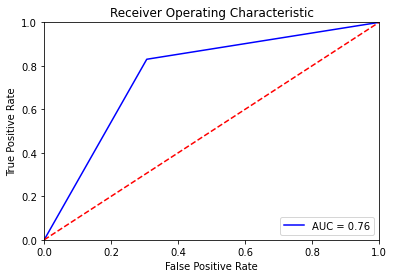

In [22]:
forest = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42,max_depth=5,max_features=3)
forest.fit(X_train_common_to, y_train_to)
y_hat = forest.predict(X_test_common_to)
print_metrics(y_test_to,y_hat)

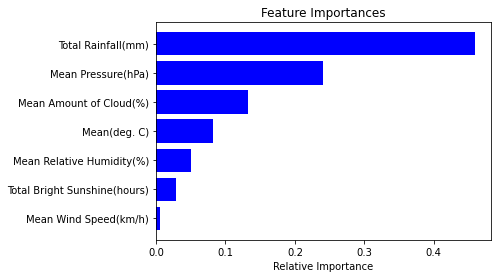

In [24]:
importances = forest.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train_common_to.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()